In [70]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import torchvision
import torch.nn.functional as F
import numpy as np
from numpy import nan
from pandas import read_csv

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from datetime import datetime
import holidays

from sympy import init_printing, Matrix
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import *

import os
import time
import sys
from tqdm import tqdm
#from tqdm.notebook import tqdm
import copy
from torchinfo import summary

In [69]:
!pip install tqdm
!pip install holidays
!pip install seaborn
!pip install tensorboard
!pip install standard-imghdr
!pip install scikit-learn
!pip install torchinfo

Pour réaliser ce travail, nous avons travailler sur la partition Juliet pour faciliter l\'exécution du code comme on peut le voir ci-dessous.

In [2]:
%%bash
nvidia-smi

Fri Feb  7 13:03:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:07:00.0 Off |                    0 |
| N/A   35C    P0             62W /  400W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [66]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return
!mkdir -p runs
!mkdir -p models

On s'occupe dans un premier d'analyser le dataset, on constate alors qu'une grande partie des données sont manquantes, on remplace alors ces valeurs manquantes dans un premier temps par des null (nan) et on rajoute une colonne. Puis comme suggéré, pour le traitement de ces données, on rajoute le nombre de wattheures restants qui peuvent être calculés à partir de l'énergie active en convertissant d'abord l'énergie active en wattheures, puis en soustrayant l'autre énergie active sous-comptée en wattheures.

In [4]:
%%skip

# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'Datetime':[0,1]}, index_col=['Datetime'])
# summarize
print(dataset.shape)
print(dataset.head())
# mark all missing values
dataset.replace('?', nan, inplace=True)
# add a column for for the remainder of sub metering
values = dataset.values.astype('float32')
dataset['Sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

On sauvegarde l'ensemble des données au format .csv et on affiche les différentes colonnes.

/tmp/ipykernel_3896223/3936465141.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

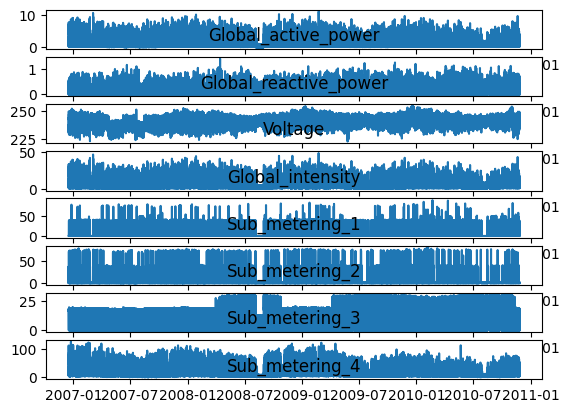

In [5]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
print(dataset.head())

plt.figure()
for i in range(len(dataset.columns)):
	plt.subplot(len(dataset.columns), 1, i+1)
	name = dataset.columns[i]
	plt.plot(dataset[name])
	plt.title(name, y=0)
plt.show()

Pour des besoins de simplification lors de l'entraînement, On utilise la méthode **resample().mean()** pour échantillonner à nouveau les données par jour et calculer la moyenne quotidienne de chaque colonne de l'ensemble de données. On fait de même pour la colonne des heures. On sauvegardera de nouveau les nouvelles données, toujours au format .csv. On affiche alors la nouvelle distribution des données.

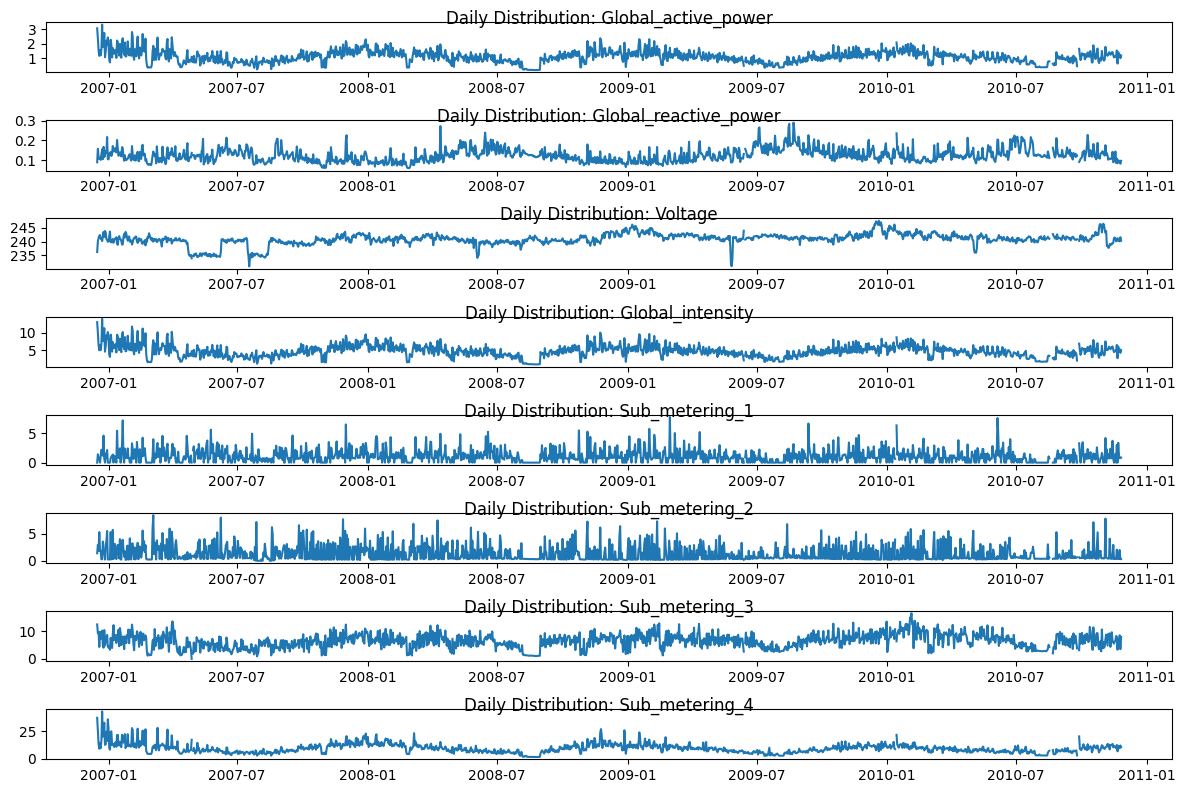

In [6]:
# Plot daily distribution
plt.figure(figsize=(12, 8))
daily_data = dataset.resample('D').mean()  # Resample by day and calculate the mean
for i in range(len(daily_data.columns)):
    plt.subplot(len(daily_data.columns), 1, i + 1)
    name = daily_data.columns[i]
    plt.plot(daily_data.index, daily_data[name])
    plt.title(f'Daily Distribution: {name}', y=0.8)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3896223/1394378584.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = dataset.resample('H').mean()  # Resample by hour and calculate the mean


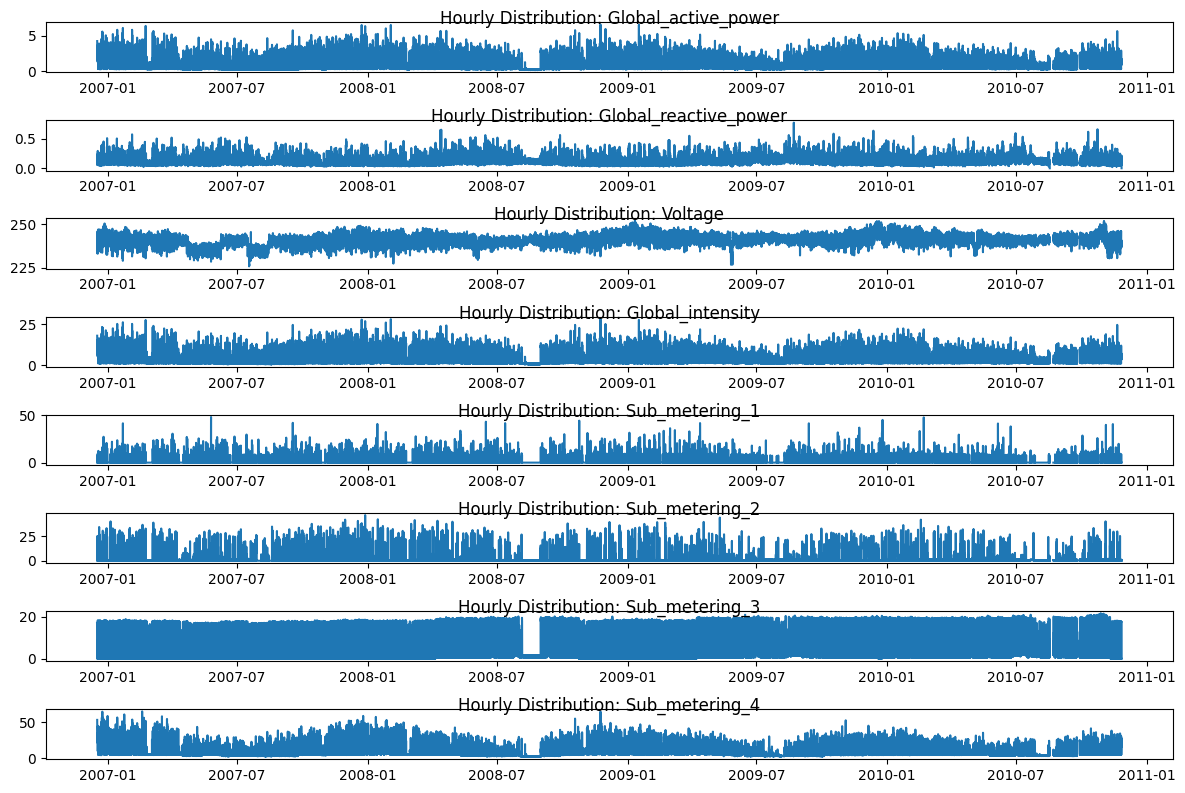

In [7]:
# Plot hourly distribution
plt.figure(figsize=(12, 8))
hourly_data = dataset.resample('H').mean()  # Resample by hour and calculate the mean
for i in range(len(hourly_data.columns)):
    plt.subplot(len(hourly_data.columns), 1, i + 1)
    name = hourly_data.columns[i]
    plt.plot(hourly_data.index, hourly_data[name])
    plt.title(f'Hourly Distribution: {name}', y=0.8)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3896223/3936465141.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

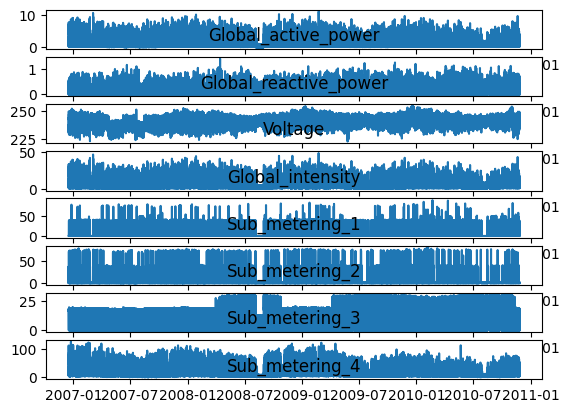

In [8]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
print(dataset.head())

plt.figure()
for i in range(len(dataset.columns)):
	plt.subplot(len(dataset.columns), 1, i+1)
	name = dataset.columns[i]
	plt.plot(dataset[name])
	plt.title(name, y=0)
plt.show()

On va réaliser une matrice de corrélation sur les données non échantillonnées et sur les données échantillonnées, afin d'identifier les features les plus utiles.

/tmp/ipykernel_3896223/1509532806.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


Matrix([
[  1.0,  0.247,   -0.4,  0.999,  0.484,  0.435,  0.639,  0.701],
[0.247,    1.0, -0.112,  0.266,  0.123,  0.139, 0.0896,  0.212],
[ -0.4, -0.112,    1.0, -0.411, -0.196, -0.167, -0.268, -0.271],
[0.999,  0.266, -0.411,    1.0,  0.489,   0.44,  0.627,  0.703],
[0.484,  0.123, -0.196,  0.489,    1.0, 0.0547,  0.103,  0.125],
[0.435,  0.139, -0.167,   0.44, 0.0547,    1.0, 0.0809, 0.0852],
[0.639, 0.0896, -0.268,  0.627,  0.103, 0.0809,    1.0,  0.179],
[0.701,  0.212, -0.271,  0.703,  0.125, 0.0852,  0.179,    1.0]])

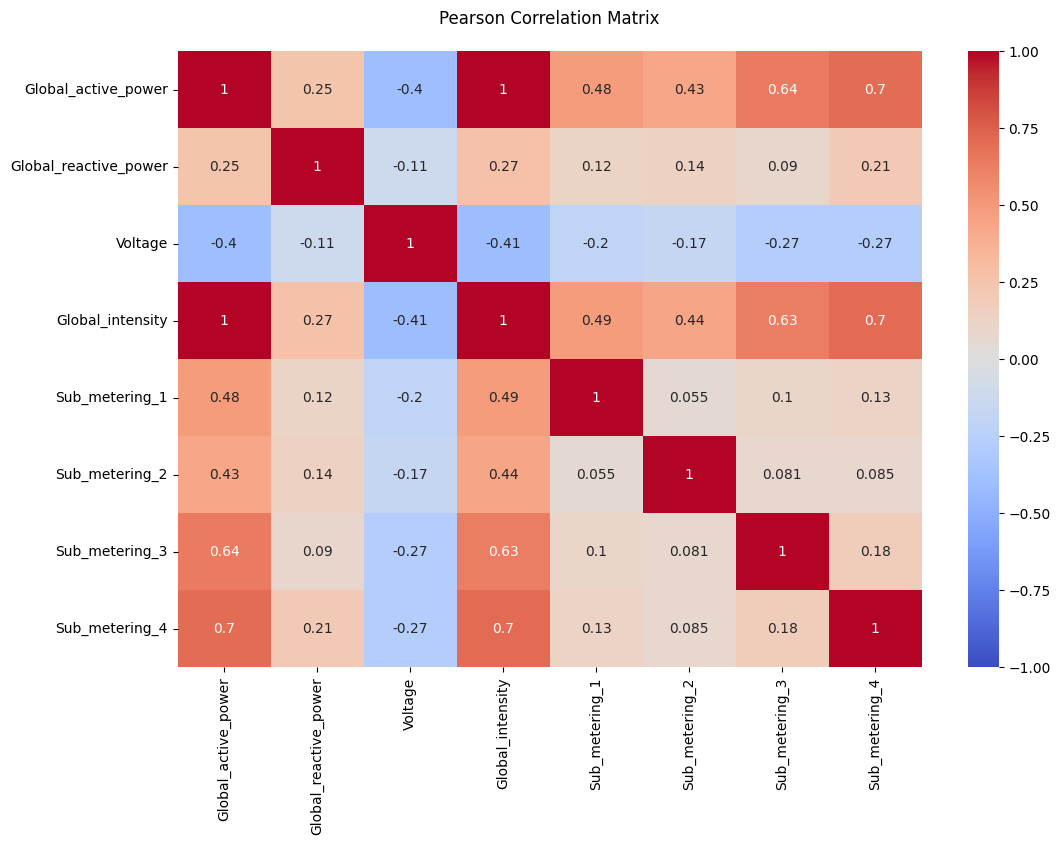

In [9]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
#print(dataset.columns)
#plot the pearson correlation matrix of the dataset which shows the correlation between the variables and labels them accordingly
correlation = dataset.corr()
#pretty print the correlation matrix here
display(Matrix(correlation).evalf(3))
# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix', pad=20)
plt.show()


/tmp/ipykernel_3896223/1481767106.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  datasetm = dataset.resample('M').mean()
/tmp/ipykernel_3896223/1481767106.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dataseth = dataset.resample('H').mean()


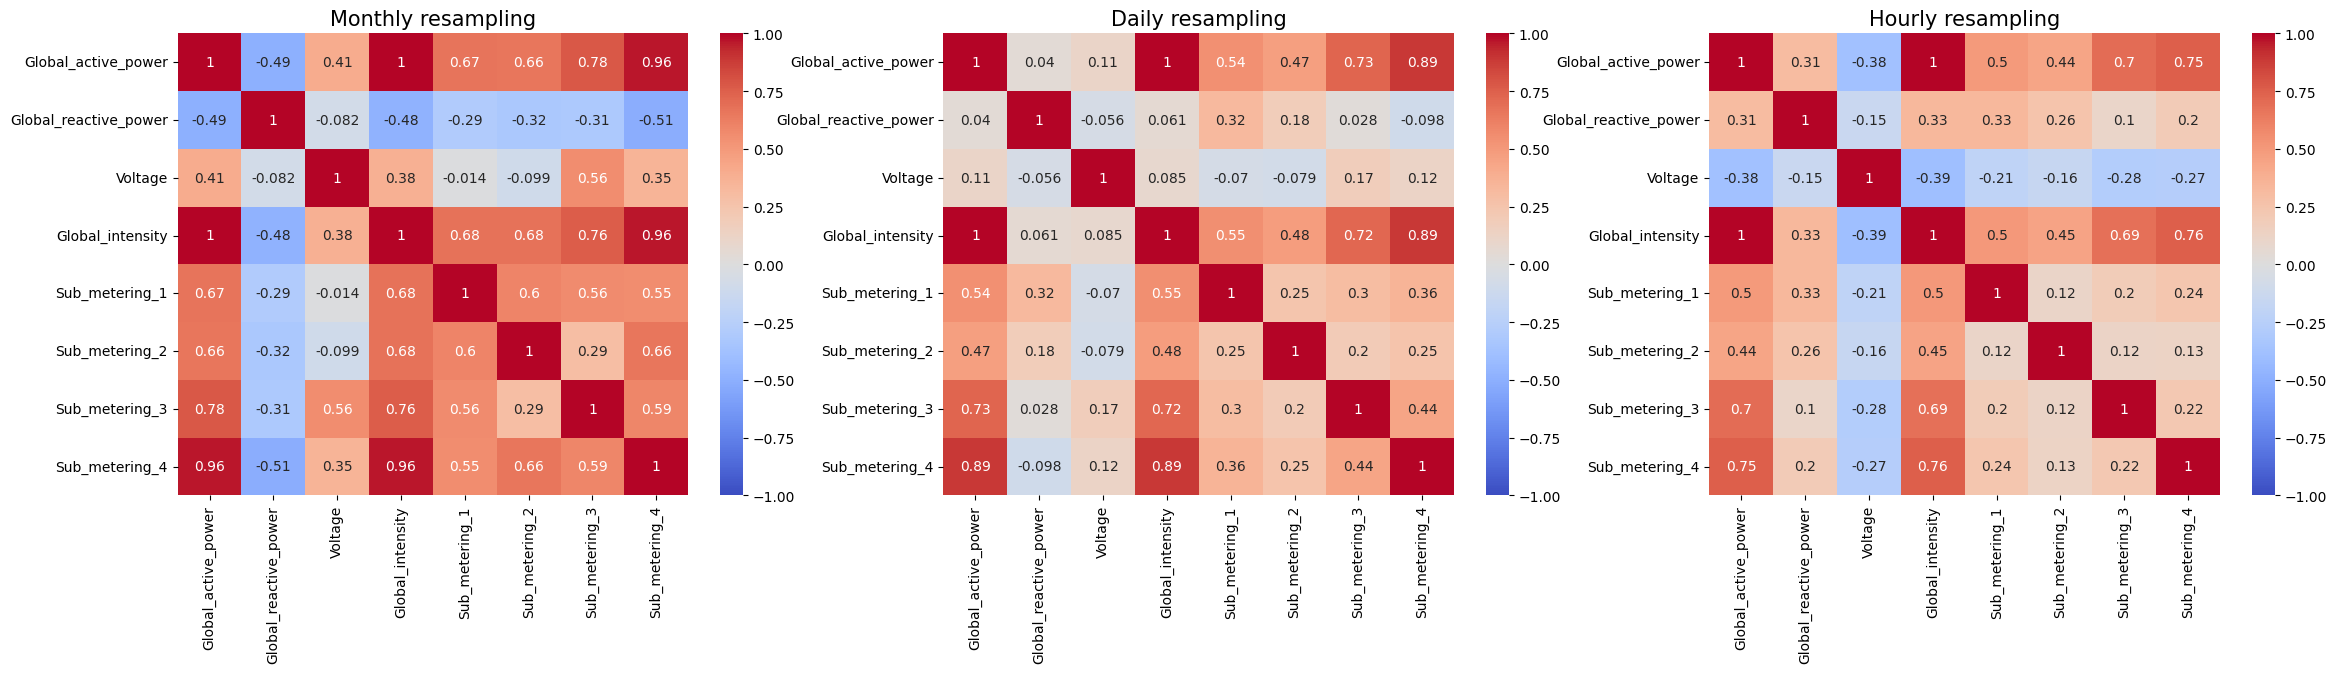

In [10]:
f= plt.figure(figsize=(28,6))

ax=f.add_subplot(131)
datasetm = dataset.resample('M').mean()
sns.heatmap(datasetm.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Monthly resampling', size=15)

ax=f.add_subplot(132)
datasetd = dataset.resample('D').mean()
sns.heatmap(datasetd.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Daily resampling', size=15)
  
ax=f.add_subplot(133)
dataseth = dataset.resample('H').mean()
sns.heatmap(dataseth.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Hourly resampling', size=15)
plt.show()

On constate alors ci-dessus qu'en fonction de la période de prédiction que l'on souhaite faire, toutes les features ne sont pas utiles. Comme pour le voltage qui n'est pas très intéressant pour la prédiction sur la consommation horaire, alors qu'elle l'est plus sur la consommation mensuelle.

Ci-dessous, on affiche le nombre de données manquantes par colonne, et on constate qu'il manque beaucoup de données.

In [11]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
#show number of missing values in each column
dataset.isnull().sum()

/tmp/ipykernel_3896223/721238349.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Sub_metering_4           25979
dtype: int64

Si on affiche aussi la distribution de nos données, on constate que chaque feature ne suit pas la même distribution.

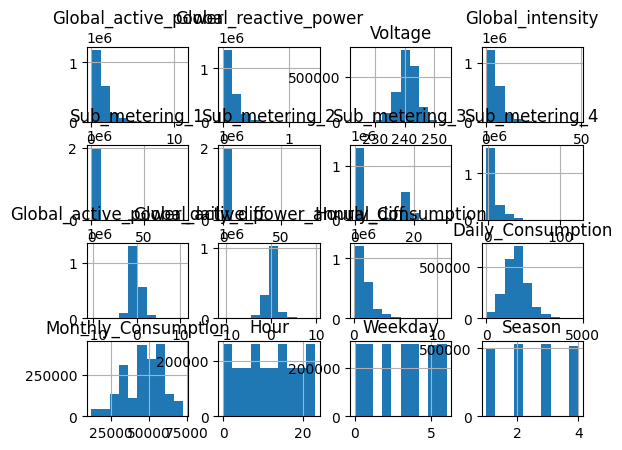


Comme la plupart de ces distributions ne sont pas normalement distribuées, nous ne pouvons pas utiliser la moyenne pour compléter les valeurs manquantes. Nous pourrions utiliser la médiane à la place. 
En outre, il est possible de normaliser l'ensemble de données, mais la normalisation doit être évitée ici, car elle rendra les données plus gaussiennes, ce qui n'est pas le cas pour cet ensemble de données.



In [73]:
#show the distrbution of all values in the dataset
dataset.hist()
plt.show()
print("""
Comme la plupart de ces distributions ne sont pas normalement distribuées, nous ne pouvons pas utiliser la moyenne pour compléter les valeurs manquantes. Nous pourrions utiliser la médiane à la place. 
En outre, il est possible de normaliser l'ensemble de données, mais la normalisation doit être évitée ici, car elle rendra les données plus gaussiennes, ce qui n'est pas le cas pour cet ensemble de données.
""")

Avec ce qui a été constaté au-dessus, on va réaliser différents traitements sur ce dataset. 

D'abord, on combine les colonnes Date et Time pour créer une nouvelle colonne `Datetime` au format `datetime`. Les colonnes originales Date et Time sont ensuite supprimées, car parfois, on constatait que la conne Datetime ne se chargez pas correctement avec l'utilisation de la fonction **read_csv()**.

Une nouvelle colonne `Sub_metering_4` est ajoutée pour représenter la différence entre la puissance active globale et la somme des sous-comptages 1, 2 et 3.

Le code calcule les différences quotidiennes et annuelles de la puissance active globale et ajoute ces différences comme nouvelles colonnes. Ces colonnes sont également converties en type float.

On ordonne chronologiquement les données.

On calcule la consommation d'énergie à différentes échelles de temps : horaire, quotidienne et mensuelle et on crée également des colonnes cibles pour les prédictions futures, comme la consommation horaire du jour suivant, la consommation quotidienne de la semaine suivante, etc.

On décide de remplacer les valeurs manquantes qui sont imputées en utilisant la médiane

On ajoute de nouvelles caractéristiques basées sur le temps sont ajoutées un indicateur de week-end, un indicateur de jour férié, et la saison.

On sauvegarde dans un nouveau fichier CSV ces nouvelles modifications.

In [13]:
%%skip
print("In any case, we will either use MinMaxScaler or RobustScaler to normalize the data. We will also use the median to fill in the missing values udring imputation of the dataset.")
#for the time, we will make a dumb LSTM model with no data processing for now for comparaison purposes

#we will create a sanatized version of the dataset, seperate from the original one and compare the two

# Load dataset
df = pd.read_csv("household_power_consumption.txt", sep=';', header=0, low_memory=False)
print(df.columns)

# Combine Date and Time manually
df = df.assign(Datetime=pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", errors="coerce"))

# Drop original Date and Time columns (optional)
df.drop(columns=["Date", "Time"], inplace=True)

# Set index if needed
#df.set_index("Datetime", inplace=True)

print(df.head())

# Define numerical columns
numeric_cols = ["Global_active_power", "Global_reactive_power", "Voltage",
                "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

df.replace('?', nan, inplace=True)

for col in numeric_cols:
    df[col] = df[col].astype(float)

# Add a column for the remainder of sub metering
df['Sub_metering_4'] = (df["Global_active_power"] * 1000 / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

# Daily differencing
df["Global_active_power_daily_diff"] = df["Global_active_power"].diff(periods=24*60)

# Annual differencing
df["Global_active_power_annual_diff"] = df["Global_active_power"].diff(periods=24*60*365)

added_cols = ["Sub_metering_4", "Global_active_power_daily_diff", "Global_active_power_annual_diff"]

for col in added_cols:
    df[col] = df[col].astype(float)
    
# Ensure Datetime is sorted
df = df.sort_values("Datetime")

# Compute energy consumption at different time scales
df["Hourly_Consumption"] = df["Global_active_power"]
df["Daily_Consumption"] = df.groupby(df["Datetime"].dt.date)["Global_active_power"].transform("sum")
df["Monthly_Consumption"] = df.groupby(df["Datetime"].dt.to_period("M"))["Global_active_power"].transform("sum")

# Create target columns (future predictions), better to include them now for normalization and scaling later after splitting the data
df["Next_Day_Hourly_Consumption"] = df["Hourly_Consumption"].shift(-24)  # Next day's same hour
df["Next_Week_Daily_Consumption"] = df["Daily_Consumption"].shift(-7)    # Daily for next week
df["Next_Month_Daily_Consumption"] = df["Daily_Consumption"].shift(-30)  # Daily for next month
df["Next_Year_Monthly_Consumption"] = df["Monthly_Consumption"].shift(-365)  # Monthly for next year

# Impute missing values and create missing indicators
for col in numeric_cols + added_cols:
    df[f"{col}_was_missing"] = df[col].isna()  # Boolean flag for missing values
    #imputation should be done after splitting the data into training and testing sets
    #df.fillna({col: df[col].median()}, inplace=True)  # Median imputation

print(df.columns)

# Sort by datetime (in case it's unordered)
df.sort_values("Datetime", inplace=True)

# Create new time-based features
df["Hour"] = df["Datetime"].dt.hour
df["Weekday"] = df["Datetime"].dt.weekday  # 0=Monday, 6=Sunday
df["Is_Weekend"] = df["Weekday"] >= 5

# Add French holiday feature
fr_holidays = holidays.FR()
df["Is_Holiday"] = df["Datetime"].dt.date.astype(str).apply(lambda x: x in fr_holidays)

# add season feature
df["Season"] = df["Datetime"].dt.month.apply(lambda x: (x % 12 + 3) // 3)

#move datetime to front of the dataframe
cols = list(df)
cols.insert(0, cols.pop(cols.index('Datetime')))
df = df.loc[:, cols]

# Save the updated dataset
df.to_csv("household_power_consumption_processed_with_features.csv", index=False)

print("Dataset updated and saved as household_power_consumption_processed_with_features.csv")


On initialise 3 fonctions qui vont permettre de remplacer les données manquantes. On a mm_scaler qui est un MinMaxScaler qui normalise les données en les mettant à l'échelle entre 0 et 1. Puis r_scaler un RobustScaler qui normalise les données en utilisant les statistiques robustes (médiane et écart interquartile), et imputer qui est un SimpleImputer qui remplit les valeurs manquantes avec la médiane de chaque colonne. À partir des tests effectués, le RobustScaler nous donne des résultats moindres lors des prédictions avec le modèle utilisant ce scaler. Nous avons alors gardé par la suite le MinMaxScaler.


Datetime                                            0
Global_active_power                             25979
Global_reactive_power                           25979
Voltage                                         25979
Global_intensity                                25979
Sub_metering_1                                  25979
Sub_metering_2                                  25979
Sub_metering_3                                  25979
Sub_metering_4                                  25979
Global_active_power_daily_diff                  37391
Global_active_power_annual_diff                555992
Hourly_Consumption                              25979
Daily_Consumption                                   0
Monthly_Consumption                                 0
Next_Day_Hourly_Consumption                     26003
Next_Week_Daily_Consumption                         7
Next_Month_Daily_Consumption                       30
Next_Year_Monthly_Consumption                     365
Global_active_power_was_miss

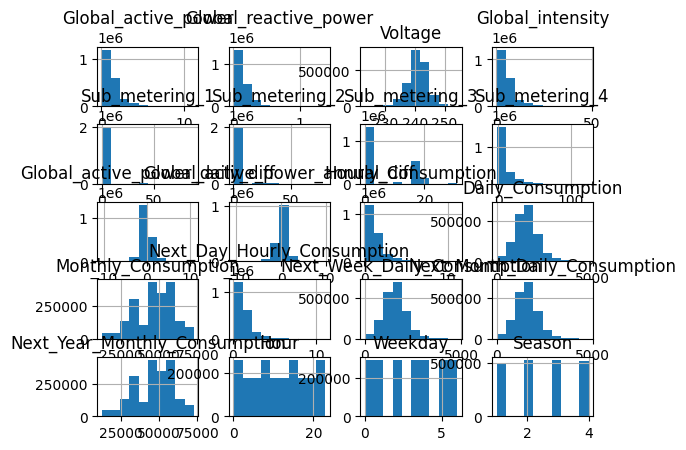

In [14]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption_processed_with_features.csv', header=0)
#show number of missing values in each column
print(dataset.isnull().sum())
mm_scaler = MinMaxScaler()
r_scaler = RobustScaler()
imputer = SimpleImputer(strategy='median')
# Apply winsorization (clipping the top and bottom 0.1%) which helps to reduce the effect of outliers, will be done after splitting and before the scaling
#lower_percentile = 0.1
#upper_percentile = 99.9
#
#for col in numeric_cols:
#    lower_limit = np.percentile(df[col], lower_percentile)
#    upper_limit = np.percentile(df[col], upper_percentile)
#    
#    # Clip values outside the 0.1% and 99.9% range
#    df[col] = np.clip(df[col], lower_limit, upper_limit)
dataset.hist()
plt.show()


On affiche une matrice de corrélations avec les nouvelles colonnes ajoutées où on constate la neutralité de ces nouvelles features par rapport aux autres.

/tmp/ipykernel_3896223/1928150395.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_copy[timestamp] = pd.to_datetime(dataset_copy[timestamp])


Matrix([
[      1.0, -0.0418,  0.0535,   0.249,  -0.0458, -0.0144,    -0.038,  0.0543, -0.0924,  0.00142,   0.0166, -0.0418,    -0.126,     -0.15,   5.43e-5, -0.000405,  -0.00233,    0.0047,     0.218],
[  -0.0418,     1.0,   0.247,    -0.4,    0.999,   0.484,     0.435,   0.639,   0.701,     0.58,    0.557,     1.0,     0.392,     0.252,     0.282,    0.0658,    0.0846,   -0.0028,    -0.127],
[   0.0535,   0.247,     1.0,  -0.112,    0.266,   0.123,     0.139,  0.0896,   0.212,    0.182,    0.192,   0.247,    0.0112,    -0.104,     0.128,    0.0695,    0.0889,   0.00809,    0.0585],
[    0.249,    -0.4,  -0.112,     1.0,   -0.411,  -0.196,    -0.167,  -0.268,  -0.271,    -0.21,   -0.221,    -0.4,    0.0752,      0.19,    -0.176,   -0.0214,   -0.0217,    0.0137,    -0.154],
[  -0.0458,   0.999,   0.266,  -0.411,      1.0,   0.489,      0.44,   0.627,   0.703,    0.581,    0.558,   0.999,     0.386,     0.242,     0.282,    0.0672,    0.0865,  -0.00281,    -0.121],
[  -0.0144,   0.484, 

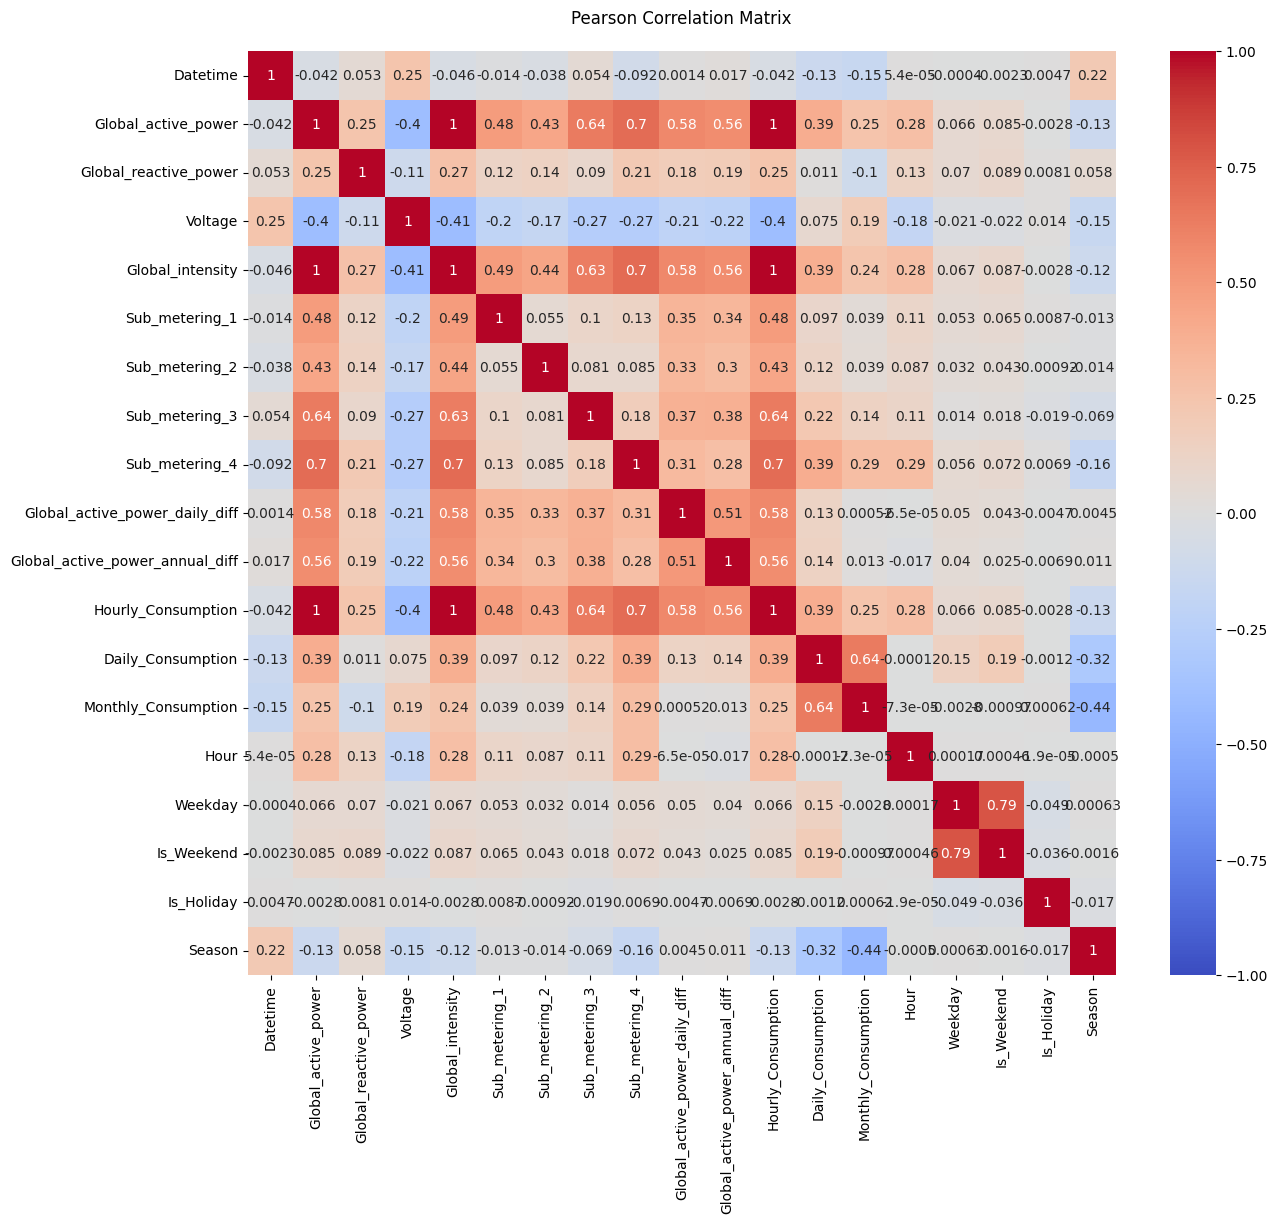

/tmp/ipykernel_3896223/1928150395.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  datasetm = dataset_copy.resample('M', on=timestamp).mean()
/tmp/ipykernel_3896223/1928150395.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dataseth = dataset_copy.resample('H', on=timestamp).mean()


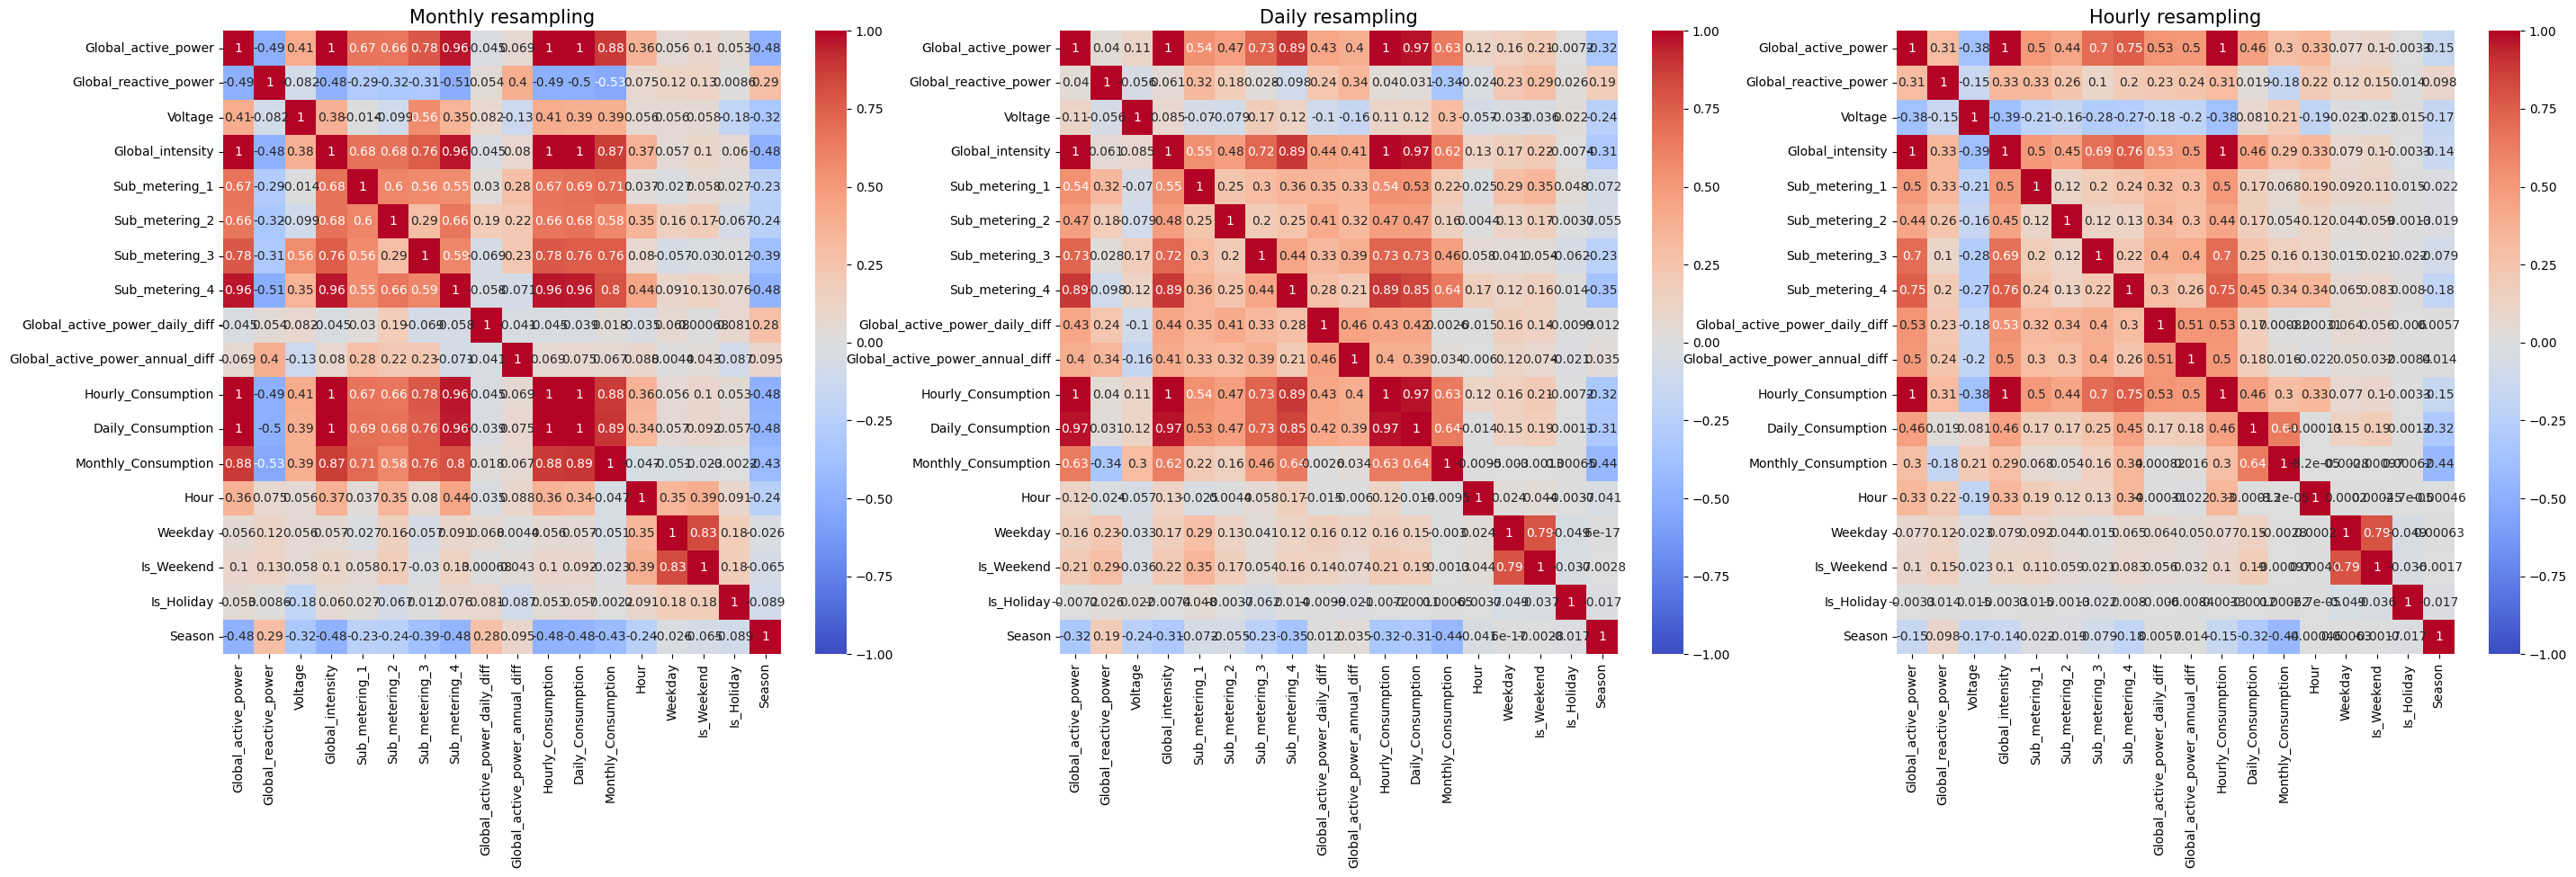

In [15]:
features = ["Next_Day_Hourly_Consumption", "Next_Week_Daily_Consumption",
                          "Next_Month_Daily_Consumption", "Next_Year_Monthly_Consumption"]
timestamp = "Datetime"
dataset_copy = dataset.loc[:, ~dataset.columns.str.contains("was_missing")]
dataset_copy[timestamp] = pd.to_datetime(dataset_copy[timestamp])
dataset_copy = dataset_copy.drop(columns=features)
correlation = dataset_copy.corr()
#pretty print the correlation matrix here
display(Matrix(correlation).evalf(3))

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix', pad=20)
plt.show()
f= plt.figure(figsize=(34,9))

ax=f.add_subplot(131)
datasetm = dataset_copy.resample('M', on=timestamp).mean()

sns.heatmap(datasetm.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Monthly resampling', size=15)

ax=f.add_subplot(132)
datasetd = dataset_copy.resample('D', on=timestamp).mean()
sns.heatmap(datasetd.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Daily resampling', size=15)
  
ax=f.add_subplot(133)
dataseth = dataset_copy.resample('H', on=timestamp).mean()
sns.heatmap(dataseth.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Hourly resampling', size=15)
plt.show()

On génère des séquences d'entrée X et des valeurs cibles y pour l'entraînement du modèle de LSTM.

In [16]:
def create_sequences(data, target_col, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback, :-1].values)  # All selected features
        y.append(data.iloc[i+lookback, target_col])  # Target value
    return np.array(X), np.array(y)

On crée une fonction ci-dessous qui sélectionne les meilleurs features à sélectionner pour réaliser l'entraînement.

In [17]:
def select_features(X, y, num_features=10):
    """
    Selects the top 'num_features' best features using SelectKBest.
    """
    selector = SelectKBest(score_func=f_regression, k=num_features)
    X_selected = selector.fit_transform(X, y)

    # Get selected feature names
    selected_features = X.columns[selector.get_support()]
    
    return selected_features

 On définit des classes d'architectures de réseaux de neurones pour traiter des séquences temporelles. LSTM2 et GRU2 sont des modèles récurrents simples qui utilisent chacun une couche LSTM ou GRU combiné à une couche linéaire, tandis que CNN_LSTM2 combine des couches convolutives pour l'extraction de caractéristiques spatiales avec un LSTM pour capturer les dépendances temporelles. Les tests de comparaisons ont été réalisées uniquement à partir du LSTM et du GRU.

In [18]:
class LSTM2(nn.Module):
    def __init__(self, hidden_size, in_size, num_layers=1, out_size=1):
        super(LSTM2, self).__init__()
        self.lstm = nn.LSTM(input_size=in_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)  # Adjusted for single output

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1, :]  # Correct indexing
        out = self.fc(last_hidden_states)
        return out, h

class GRU2(nn.Module):
    def __init__(self, hidden_size, in_size, num_layers=1, out_size=1):
        super(GRU2, self).__init__()
        self.gru = nn.GRU(input_size=in_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)  # Adjusted for single output

    def forward(self, x, h=None):
        out, h = self.gru(x, h)
        last_hidden_states = out[:, -1, :]  # Get last time step's hidden state
        out = self.fc(last_hidden_states)
        return out, h

class CNN_LSTM2(nn.Module):
    def __init__(self, in_channels, seq_len, num_features, hidden_size, num_lstm_layers=1, out_size=1):
        super(CNN_LSTM2, self).__init__()

        # CNN Feature Extraction
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate CNN output size after convolutions & pooling
        cnn_output_size = (seq_len // 2) * 32  # After pooling once (assuming stride=2)

        # LSTM
        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size,
                            num_layers=num_lstm_layers, batch_first=True)

        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        # CNN Part (Expecting shape: [batch, seq_len, num_features])
        x = x.permute(0, 2, 1)  # Reshape to [batch, num_features, seq_len] for 1D CNN
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))

        # Reshape for LSTM: [batch, seq_len/2, num_features*channels]
        x = x.reshape(x.shape[0], -1, x.shape[1] * x.shape[2])

        # LSTM Part
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last timestep output

        return out

On définit une fonction `train_lstm_model` qui entraîne un modèle LSTM  sur un ensemble de données, évalue ses performances sur des ensembles de validation et de test, et renvoie le meilleur modèle trouvé ainsi que l'historique des pertes d'entraînement et de validation. Voici une explication détaillée de ce que fait chaque partie du code :

La fonction `train_lstm_model` prend en entrée plusieurs paramètres, notamment le modèle à entraîner, les chargeurs de données pour les ensembles d'entraînement, de validation et de test, un objet de mise à l'échelle pour inverser la transformation des données, un optimiseur, une fonction de perte, et divers autres paramètres comme le nombre d'époques et le dispositif d'entraînement (CPU ou GPU).

Après l'entraînement, le meilleur modèle est évalué sur l'ensemble de test. Les prédictions et les valeurs réelles sont collectées et transformées à l'échelle originale à l'aide de l'objet de mise à l'échelle. Les prédictions et les valeurs réelles sont ensuite tracées pour visualiser les performances du modèle sur l'ensemble de test. Enfin, les courbes de perte, d'entraînement et de validation sont tracées pour montrer l'évolution des pertes au fil des époques. La fonction renvoie le meilleur modèle trouvé, ainsi que les historiques des pertes d'entraînement et de validation.

In [46]:

def train_lstm_model(model, train_loader, val_loader, test_loader, scaler, optimizer, loss_fn, features, train_size, epochs=100, device="cpu", scaling=True, is_lstm=True, title=""):
    """
    Trains an LSTM model and evaluates it on validation and test sets using DataLoader.
    
    Parameters:
        model (torch.nn.Module): LSTM model
        train_loader (torch.utils.data.DataLoader): DataLoader for training data
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data
        test_loader (torch.utils.data.DataLoader): DataLoader for test data
        scaler (sklearn.preprocessing.StandardScaler): Scaler for inverse transform
        optimizer (torch.optim.Optimizer): Optimizer for training
        loss_fn (callable): Loss function
        epochs (int): Number of training epochs (default=100)
        device (str): Device to train on ('cpu' or 'cuda')

    Returns:
        best_model (torch.nn.Module): The best trained model
        training_loss (list): Training loss history
        validation_loss (list): Validation loss history
    """

    model.to(device)
    
    best_model = None
    min_val_loss = sys.maxsize

    training_loss = []
    validation_loss = []
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/LSTM_trainer_{}'.format(timestamp))

    log_freq=20
    num_batches = len(train_loader)
    log_interval = max(1, num_batches // log_freq)
    
    for epoch in range(epochs+1):
        model.train(True)
        epoch_train_loss = 0.0
        running_loss = 0.0
        i = 0
        
        # Training loop over batches
        for x_batch, y_batch in tqdm(train_loader, desc="Epoch Progress", unit="batch", leave=False, total=len(train_loader)):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            y_pred, _ = model(x_batch)
            
            loss = loss_fn(y_pred, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            running_loss += loss.item()

            if i % log_interval == (log_interval - 1):
                last_loss = running_loss / log_interval
                tb_x = epoch * num_batches + i + 1
                writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.0
            i += 1

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        training_loss.append(epoch_train_loss)

        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in tqdm(val_loader, desc="Validation Progress", unit="batch", leave=False, total=len(val_loader)):
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                
                y_pred, _ = model(x_val_batch)
                
                val_loss = loss_fn(y_pred, y_val_batch)
                epoch_val_loss += val_loss.item()

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader)
        validation_loss.append(epoch_val_loss)

        # Save the best model based on validation loss
        if epoch_val_loss < min_val_loss:
            best_model = copy.deepcopy(model)
            min_val_loss = epoch_val_loss

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f'Epoch {epoch}: Train Loss = {round(epoch_train_loss, 4)}, '
                      f'Val Loss = {round(epoch_val_loss, 4)}')

    # Evaluation on test set
    best_model.eval()
    predicted = []
    real = []
    
    with torch.no_grad():
        for x_test_batch, y_test_batch in tqdm(test_loader, desc="Test Progress", unit="batch", total=len(test_loader)):
            x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)

            if is_lstm:
                _, h_list = model(x_test_batch)
                h = tuple([h[-1].unsqueeze(0).to(device) for h in h_list])  # Ensure correct shape
            else:
                _, h_list = model(x_test_batch)
                h = h_list.unsqueeze(0).to(device) if h_list.dim() == 2 else h_list.to(device)

            y_pred, _ = model(x_test_batch, h)

            predicted.extend(y_pred.cpu().numpy())
            real.extend(y_test_batch.cpu().numpy())

    print(len(test_loader))

    print(len(predicted), len(real))
    
    predicted = np.array(predicted).reshape(-1, 1)
    real = np.array(real).reshape(-1, 1)

    print(predicted.shape, real.shape)

    # Convert back to original scale (if needed)
    predicted = scaler.inverse_transform(np.hstack([np.zeros((predicted.shape[0], len(features))), predicted]))[:, -1]
    real = scaler.inverse_transform(np.hstack([np.zeros((real.shape[0], len(features))), real]))[:, -1]

    print(predicted.shape, real.shape)

    # Plot test predictions
    plt.figure(figsize=(10, 4))
    plt.title(f"Test Dataset {title} Predictions")
    plt.plot(real, label='Real', color='green')  # Keep real values solid
    plt.plot(predicted, label='Predicted', linestyle='--', alpha=0.6, color='red')  # Dashed + see-through
    plt.axvline(x=train_size, c='yellow', linestyle='--') # train size delimitation
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.title('Training Loss Curve')
    plt.yscale('log')
    plt.plot(training_loss, label='Training')
    plt.plot(validation_loss, label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return best_model, training_loss, validation_loss

On fais une fonction **save_model()** permettant de sauvegarder le modèle.

In [20]:
def save_model(model, architecture_name, target_name, directory="models/"):
    """
    Saves a trained PyTorch model with a filename based on its architecture and target variable.
    """

    os.makedirs(directory, exist_ok=True)

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    model_filename = f"{directory}{architecture_name}_{target_name}_{timestamp}.pth"

    # saves the model
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")

    return model_filename


On définti une fonction permettant de charger les différentes données sous la forme de tenseurs.

In [71]:
def load_torch_dataset(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64, num_workers=0, train_shuffle=False):
    # Convert to PyTorch tensors
    X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Ensure correct shape
    
    X_val_torch = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_torch = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
    
    X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Create DataLoader
    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, num_workers=num_workers, shuffle=train_shuffle)
    val_loader = DataLoader(TensorDataset(X_val_torch, y_val_torch), batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, val_loader, test_loader

On définit la fonction `calculate_metrics` qui évalue un modèle sur un ensemble de données en calculant trois métriques de performance : l'erreur quadratique moyenne (MSE), l'erreur absolue moyenne (MAE) et la racine de l'erreur quadratique moyenne (RMSE). Elle commence par déplacer le modèle vers le dispositif spécifié (CPU ou GPU) et le met en mode évaluation. Ensuite, elle parcourt les lots de données fournis par une instance de DataLoader de Pytorch, génère des prédictions avec le modèle, et calcule les erreurs MSE et MAE pour chaque lot. Ces erreurs sont accumulées et moyennées sur l'ensemble des échantillons pour obtenir les valeurs finales de MSE, MAE et RMSE, qui sont ensuite retournées.

In [22]:
def calculate_metrics(model, data_loader, device):
    model.to(device)
    
    model.eval()  # Set the model to evaluation mode
    total_mse = 0
    total_mae = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)

            # Calculate MSE and MAE
            mse = torch.mean((outputs - labels) ** 2)
            mae = torch.mean(torch.abs(outputs - labels))

            total_mse += mse.item() * inputs.size(0)
            total_mae += mae.item() * inputs.size(0)
            total_samples += inputs.size(0)

    # Average over all samples
    mse = total_mse / total_samples
    mae = total_mae / total_samples
    rmse = torch.sqrt(torch.tensor(mse)).item()  # Calculate RMSE

    return mse, mae, rmse

On définit un optimiseur ici Adam pour l'entraînement.

In [62]:
def get_optimizer(model, learning_rate, regularization=0):
    return torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)

In [51]:
%reload_ext tensorboard
logs_base_dir = "./runs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [25]:
import torch

torch.cuda.empty_cache()  # Releases unused memory
torch.cuda.reset_peak_memory_stats()  # Resets memory tracking

Les prédictions a effectué sont ici :

* La consommation horaire du lendemain
* la consommation journalière pour la semaine prochaine
* la consommation journalière pour le mois prochain
* la consommation mensuelle pour l'année prochaine

Le problème avec ces prédictions est que pour les prédictions mensuelles, on doit diminuer le nombre d'entrées dans notre dataset est donc de potentiellement avoir un entrainement moins performant avec des batches à gros grains.  
Une idée pour améliorer l'entrainement serait d'éviter le resampling et de garder un nombre d'entrées dans le dataset raisonnable, on pourrait rester sur un sampling sur l'heure et faire les prédictions à partir de celle-ci.  
Ceci demande alors de modifier la construction des fenêtres glissantes pour prendre cela en compte. La fonction ci-dessous a pour but de faire cela, mais son implémentation ne marche pas pour le moment.

In [67]:
#WIP
def create_sequences_sampled(data, target_col, lookback, prediction_type="hourly"):
    X, y = [], []
    
    for i in range(len(data) - lookback - (24*7 if prediction_type == "weekly" else (24 if prediction_type == "daily" else 1))):
        # Extract past `lookback` hours of features
        X.append(data.iloc[i:i+lookback, :-1].values)  # All selected features
        
        if prediction_type == "hourly":
            y.append(data.iloc[i + lookback, target_col])  # Predict next hour
        
        elif prediction_type == "daily":
            y.append(data.iloc[i + lookback:i + lookback + 24, target_col].mean())  # Predict next day's average
            
        elif prediction_type == "weekly":
            y.append(data.iloc[i + lookback:i + lookback + 24*7, target_col].resample('D').mean().values)  # Predict next week's daily avg

    return np.array(X), np.array(y)


On réalise l'entraînement avec différents paramètres et différents modèles qui ont été définis précédemment. On utilise notamment la fonction de sélection automatique des features intéressantes pour le modèle multi-input, single-output ainsi qu'une sélection manuelle de certaines colonnes qui paraissent intéressantes d'un point de vue humain (la saison, les jours fériées, le weekend).

Using device: cuda:1
Columns with all NaN values: []
Training for hourly (sampling for 24 - auto)
Global_active_power                             421
Global_reactive_power                           421
Voltage                                         421
Global_intensity                                421
Sub_metering_1                                  421
Sub_metering_2                                  421
Sub_metering_3                                  421
Sub_metering_4                                  421
Global_active_power_daily_diff                  604
Global_active_power_annual_diff                9249
Hourly_Consumption                              421
Daily_Consumption                                 0
Monthly_Consumption                               0
Global_active_power_was_missing                   0
Global_reactive_power_was_missing                 0
Voltage_was_missing                               0
Global_intensity_was_missing                      0
Sub_metering_1_was

Epoch 1/100
Epoch 0: Train Loss = 0.0095, Val Loss = 0.0078


Epoch 11/100
Epoch 10: Train Loss = 0.0062, Val Loss = 0.0072


Epoch 21/100
Epoch 20: Train Loss = 0.0059, Val Loss = 0.0069


Epoch 31/100
Epoch 30: Train Loss = 0.0058, Val Loss = 0.0068


Epoch 41/100
Epoch 40: Train Loss = 0.0057, Val Loss = 0.0067


Epoch 51/100
Epoch 50: Train Loss = 0.0057, Val Loss = 0.0065


Epoch 61/100
Epoch 60: Train Loss = 0.0057, Val Loss = 0.0062


Epoch 71/100
Epoch 70: Train Loss = 0.0056, Val Loss = 0.0061


Epoch 81/100
Epoch 80: Train Loss = 0.0056, Val Loss = 0.006


Epoch 91/100
Epoch 90: Train Loss = 0.0055, Val Loss = 0.0061


Epoch 101/100
Epoch 100: Train Loss = 0.0055, Val Loss = 0.0061


Test Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1094.06batch/s]


61
3872 3872
(3872, 1) (3872, 1)
(3872,) (3872,)


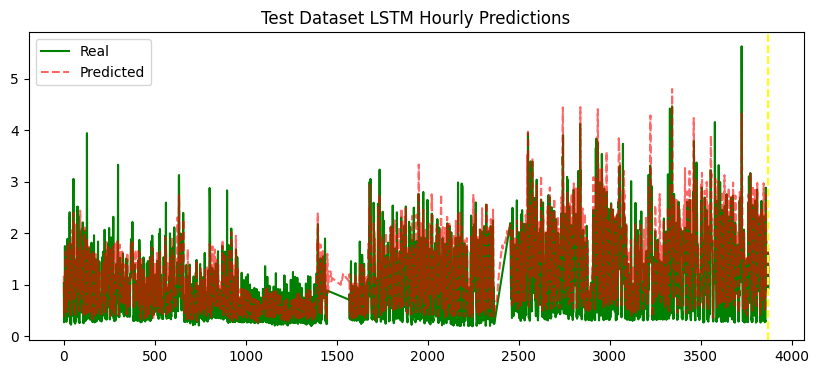

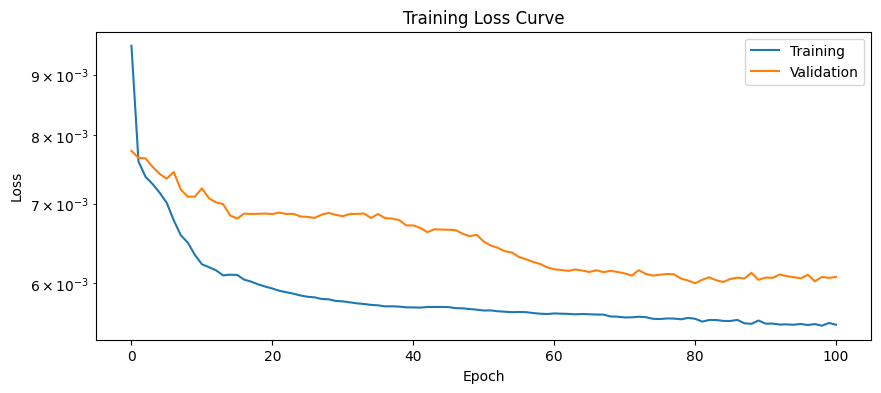

MSE: 0.0055, MAE: 0.0566, RMSE: 0.0740
Model saved as models/lstm_hourly_consumption_prediction_20250207-142850.pth
Layer (type:depth-idx)                   Output Shape              Param #
GRU2                                     [64, 1]                   --
├─GRU: 1-1                               [64, 24, 128]             54,528
├─Linear: 1-2                            [64, 1]                   129
Total params: 54,657
Trainable params: 54,657
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 83.76
Input size (MB): 0.07
Forward/backward pass size (MB): 1.57
Params size (MB): 0.22
Estimated Total Size (MB): 1.87


Epoch 1/100
Epoch 0: Train Loss = 0.0092, Val Loss = 0.0079


Epoch 11/100
Epoch 10: Train Loss = 0.0067, Val Loss = 0.0074


Epoch 21/100
Epoch 20: Train Loss = 0.0062, Val Loss = 0.0066


Epoch 31/100
Epoch 30: Train Loss = 0.006, Val Loss = 0.0063


Epoch 41/100
Epoch 40: Train Loss = 0.0059, Val Loss = 0.0062


Epoch 51/100
Epoch 50: Train Loss = 0.0058, Val Loss = 0.0061


Epoch 61/100
Epoch 60: Train Loss = 0.0058, Val Loss = 0.0061


Epoch 71/100
Epoch 70: Train Loss = 0.0057, Val Loss = 0.006


Epoch 81/100
Epoch 80: Train Loss = 0.0056, Val Loss = 0.0059


Epoch 91/100
Epoch 90: Train Loss = 0.0056, Val Loss = 0.0059


Epoch 101/100
Epoch 100: Train Loss = 0.0056, Val Loss = 0.0059


Test Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1198.23batch/s]


61
3872 3872
(3872, 1) (3872, 1)
(3872,) (3872,)


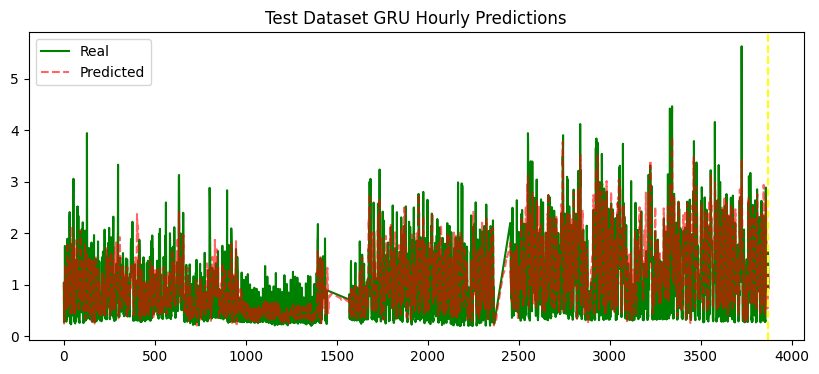

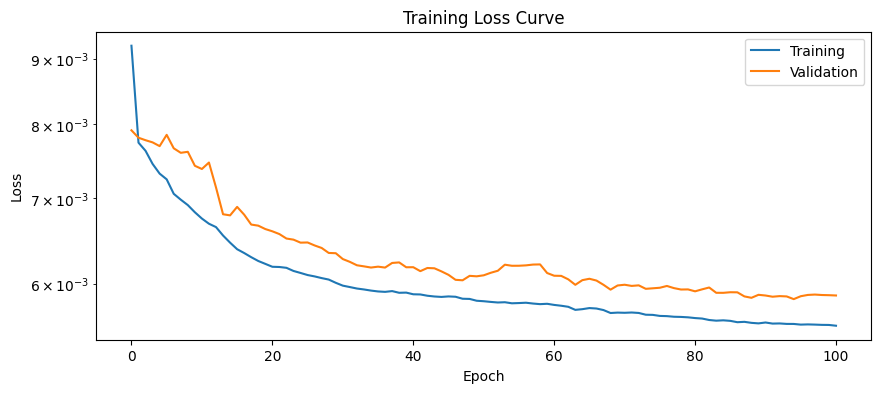

MSE: 0.0048, MAE: 0.0504, RMSE: 0.0689
Model saved as models/gru_hourly_consumption_prediction_20250207-142939.pth
Training for weekly (sampling for 7 - auto)
Global_active_power                              9
Global_reactive_power                            9
Voltage                                          9
Global_intensity                                 9
Sub_metering_1                                   9
Sub_metering_2                                   9
Sub_metering_3                                   9
Sub_metering_4                                   9
Global_active_power_daily_diff                  16
Global_active_power_annual_diff                375
Hourly_Consumption                               9
Daily_Consumption                                0
Monthly_Consumption                              0
Global_active_power_was_missing                  0
Global_reactive_power_was_missing                0
Voltage_was_missing                              0
Global_intensity_was_miss

Epoch 1/100
Epoch 0: Train Loss = 0.0617, Val Loss = 0.0157


Epoch 11/100
Epoch 10: Train Loss = 0.0153, Val Loss = 0.0137


Epoch 21/100
Epoch 20: Train Loss = 0.0138, Val Loss = 0.0141


Epoch 31/100
Epoch 30: Train Loss = 0.0124, Val Loss = 0.0163


Epoch 41/100
Epoch 40: Train Loss = 0.0121, Val Loss = 0.0142


Epoch 51/100
Epoch 50: Train Loss = 0.0119, Val Loss = 0.0173


Epoch 61/100
Epoch 60: Train Loss = 0.0103, Val Loss = 0.0153


Epoch 71/100
Epoch 70: Train Loss = 0.0108, Val Loss = 0.0171


Epoch 81/100
Epoch 80: Train Loss = 0.0104, Val Loss = 0.0176


Epoch 91/100
Epoch 90: Train Loss = 0.0082, Val Loss = 0.0197


Epoch 101/100
Epoch 100: Train Loss = 0.0088, Val Loss = 0.0206


Test Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1301.57batch/s]


6
161 161
(161, 1) (161, 1)
(161,) (161,)


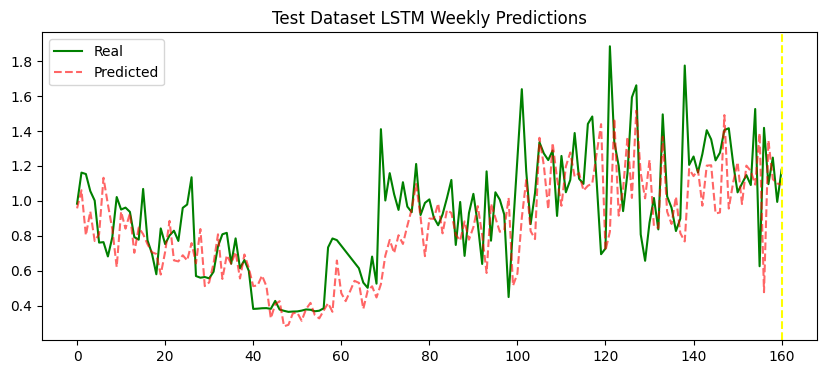

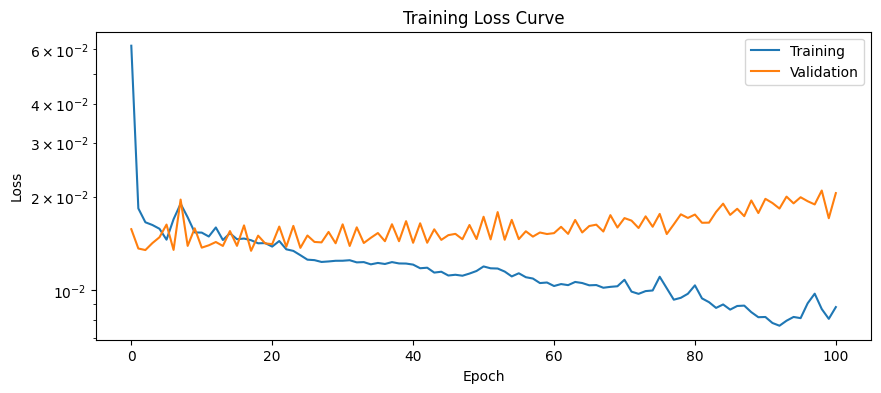

MSE: 0.0119, MAE: 0.0803, RMSE: 0.1091
Model saved as models/lstm_weekly_consumption_prediction_20250207-142945.pth
Layer (type:depth-idx)                   Output Shape              Param #
GRU2                                     [32, 1]                   --
├─GRU: 1-1                               [32, 7, 128]              54,528
├─Linear: 1-2                            [32, 1]                   129
Total params: 54,657
Trainable params: 54,657
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 12.22
Input size (MB): 0.01
Forward/backward pass size (MB): 0.23
Params size (MB): 0.22
Estimated Total Size (MB): 0.46


Epoch 1/100
Epoch 0: Train Loss = 0.0492, Val Loss = 0.0175


Epoch 11/100
Epoch 10: Train Loss = 0.0152, Val Loss = 0.016


Epoch 21/100
Epoch 20: Train Loss = 0.0124, Val Loss = 0.0156


Epoch 31/100
Epoch 30: Train Loss = 0.0128, Val Loss = 0.0148


Epoch 41/100
Epoch 40: Train Loss = 0.0109, Val Loss = 0.0146


Epoch 51/100
Epoch 50: Train Loss = 0.0116, Val Loss = 0.0155


Epoch 61/100
Epoch 60: Train Loss = 0.0104, Val Loss = 0.0161


Epoch 71/100
Epoch 70: Train Loss = 0.0092, Val Loss = 0.0157


Epoch 81/100
Epoch 80: Train Loss = 0.0086, Val Loss = 0.0189


Epoch 91/100
Epoch 90: Train Loss = 0.0094, Val Loss = 0.0206


Epoch 101/100
Epoch 100: Train Loss = 0.0091, Val Loss = 0.0231


Test Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1371.66batch/s]


6
161 161
(161, 1) (161, 1)
(161,) (161,)


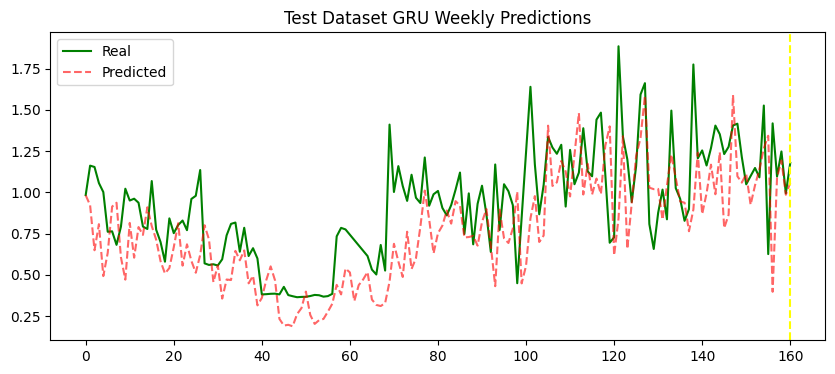

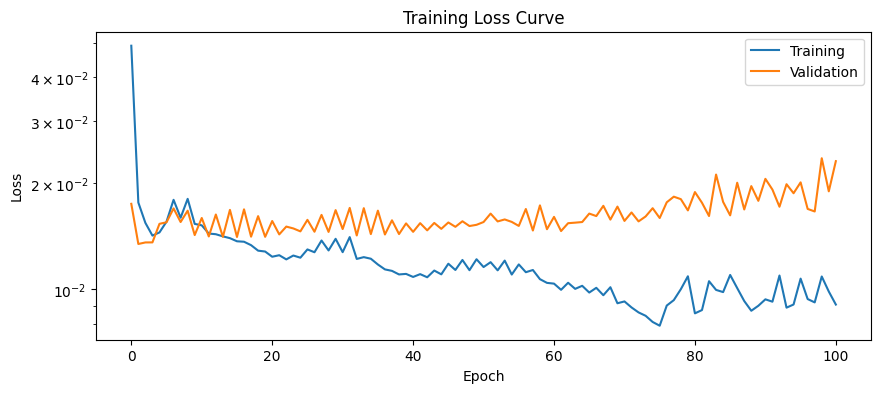

MSE: 0.0125, MAE: 0.0820, RMSE: 0.1118
Model saved as models/gru_weekly_consumption_prediction_20250207-142949.pth
Training for monthly (sampling for 30 - auto)
Global_active_power                              9
Global_reactive_power                            9
Voltage                                          9
Global_intensity                                 9
Sub_metering_1                                   9
Sub_metering_2                                   9
Sub_metering_3                                   9
Sub_metering_4                                   9
Global_active_power_daily_diff                  16
Global_active_power_annual_diff                375
Hourly_Consumption                               9
Daily_Consumption                                0
Monthly_Consumption                              0
Global_active_power_was_missing                  0
Global_reactive_power_was_missing                0
Voltage_was_missing                              0
Global_intensity_was_mi

Epoch 1/100
Epoch 0: Train Loss = 0.0419, Val Loss = 0.0276


Epoch 11/100
Epoch 10: Train Loss = 0.0144, Val Loss = 0.0126


Epoch 21/100
Epoch 20: Train Loss = 0.0123, Val Loss = 0.0123


Epoch 31/100
Epoch 30: Train Loss = 0.0121, Val Loss = 0.0135


Epoch 41/100
Epoch 40: Train Loss = 0.0113, Val Loss = 0.0144


Epoch 51/100
Epoch 50: Train Loss = 0.0121, Val Loss = 0.0139


Epoch 61/100
Epoch 60: Train Loss = 0.0101, Val Loss = 0.0151


Epoch 71/100
Epoch 70: Train Loss = 0.0094, Val Loss = 0.0173


Epoch 81/100
Epoch 80: Train Loss = 0.0095, Val Loss = 0.0175


Epoch 91/100
Epoch 90: Train Loss = 0.0086, Val Loss = 0.0189


Epoch 101/100
Epoch 100: Train Loss = 0.0077, Val Loss = 0.0205


Test Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1361.48batch/s]


10
158 158
(158, 1) (158, 1)
(158,) (158,)


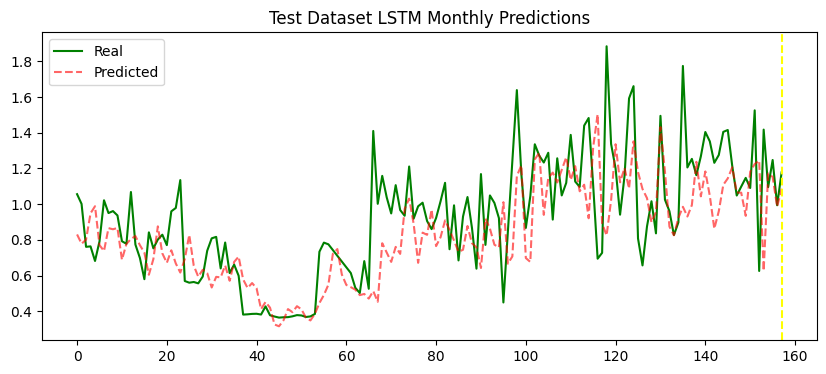

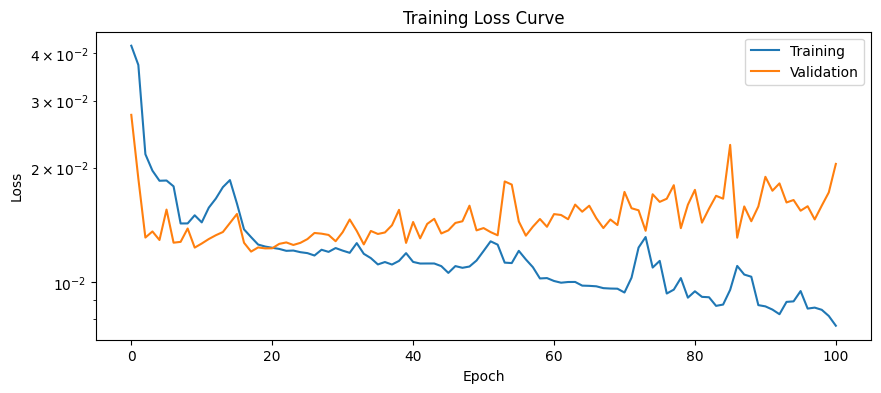

MSE: 0.0125, MAE: 0.0810, RMSE: 0.1119
Model saved as models/lstm_monthly_consumption_prediction_20250207-142958.pth
Layer (type:depth-idx)                   Output Shape              Param #
GRU2                                     [16, 1]                   --
├─GRU: 1-1                               [16, 30, 128]             54,528
├─Linear: 1-2                            [16, 1]                   129
Total params: 54,657
Trainable params: 54,657
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 26.18
Input size (MB): 0.02
Forward/backward pass size (MB): 0.49
Params size (MB): 0.22
Estimated Total Size (MB): 0.73


Epoch 1/100
Epoch 0: Train Loss = 0.0341, Val Loss = 0.0308


Epoch 11/100
Epoch 10: Train Loss = 0.013, Val Loss = 0.0126


Epoch 21/100
Epoch 20: Train Loss = 0.0123, Val Loss = 0.0134


Epoch 31/100
Epoch 30: Train Loss = 0.0129, Val Loss = 0.0147


Epoch 41/100
Epoch 40: Train Loss = 0.0121, Val Loss = 0.0165


Epoch 51/100
Epoch 50: Train Loss = 0.0112, Val Loss = 0.0173


Epoch 61/100
Epoch 60: Train Loss = 0.009, Val Loss = 0.0178


Epoch 71/100
Epoch 70: Train Loss = 0.0083, Val Loss = 0.0171


Epoch 81/100
Epoch 80: Train Loss = 0.0085, Val Loss = 0.0159


Epoch 91/100
Epoch 90: Train Loss = 0.0078, Val Loss = 0.0185


Epoch 101/100
Epoch 100: Train Loss = 0.0066, Val Loss = 0.0213


Test Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1539.19batch/s]


10
158 158
(158, 1) (158, 1)
(158,) (158,)


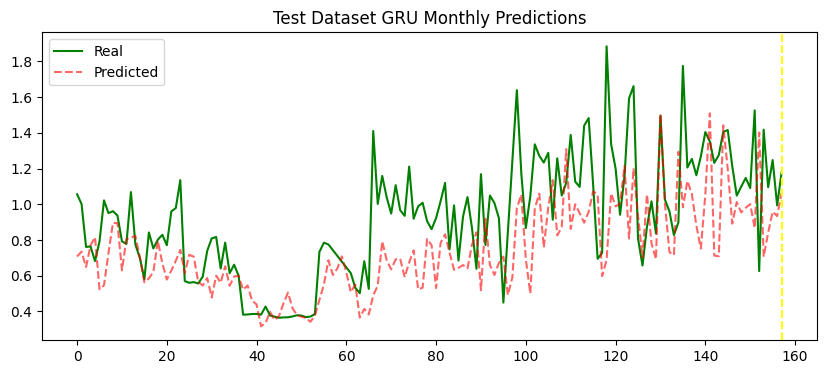

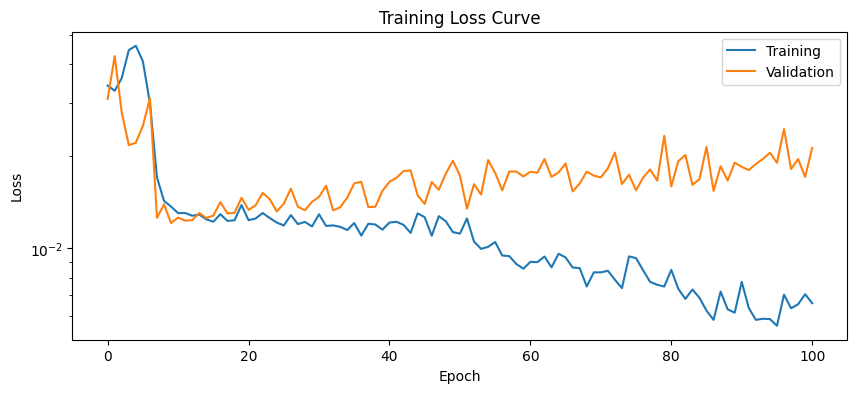

MSE: 0.0127, MAE: 0.0820, RMSE: 0.1127
Model saved as models/gru_monthly_consumption_prediction_20250207-143005.pth
Training for yearly (sampling for 12 - auto)
Global_active_power                             0
Global_reactive_power                           0
Voltage                                         0
Global_intensity                                0
Sub_metering_1                                  0
Sub_metering_2                                  0
Sub_metering_3                                  0
Sub_metering_4                                  0
Global_active_power_daily_diff                  0
Global_active_power_annual_diff                12
Hourly_Consumption                              0
Daily_Consumption                               0
Monthly_Consumption                             0
Global_active_power_was_missing                 0
Global_reactive_power_was_missing               0
Voltage_was_missing                             0
Global_intensity_was_missing           

Epoch 1/100
Epoch 0: Train Loss = 0.2343, Val Loss = 0.1615


Epoch 11/100
Epoch 10: Train Loss = 0.0081, Val Loss = 0.0105


Epoch 21/100
Epoch 20: Train Loss = 0.003, Val Loss = 0.0141


Epoch 31/100
Epoch 30: Train Loss = 0.0019, Val Loss = 0.0169


Epoch 41/100
Epoch 40: Train Loss = 0.0012, Val Loss = 0.0136


Epoch 51/100
Epoch 50: Train Loss = 0.0009, Val Loss = 0.0158


Epoch 61/100
Epoch 60: Train Loss = 0.0007, Val Loss = 0.0187


Epoch 71/100
Epoch 70: Train Loss = 0.0009, Val Loss = 0.0167


Epoch 81/100
Epoch 80: Train Loss = 0.0003, Val Loss = 0.0196


Epoch 91/100
Epoch 90: Train Loss = 0.0002, Val Loss = 0.0219


Epoch 101/100
Epoch 100: Train Loss = 0.0015, Val Loss = 0.0202


Test Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1311.95batch/s]


2
5 5
(5, 1) (5, 1)
(5,) (5,)


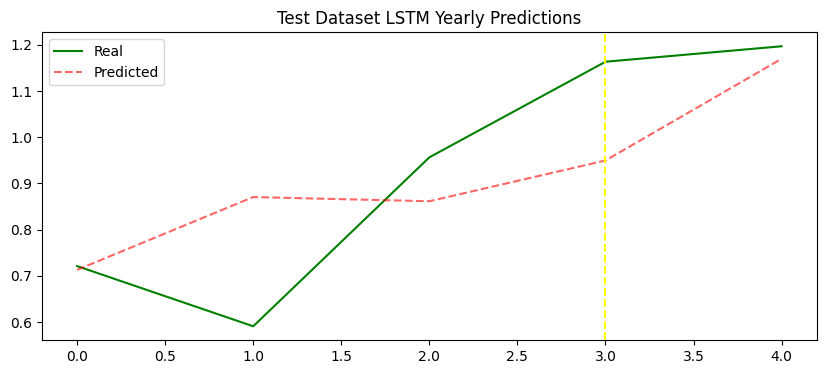

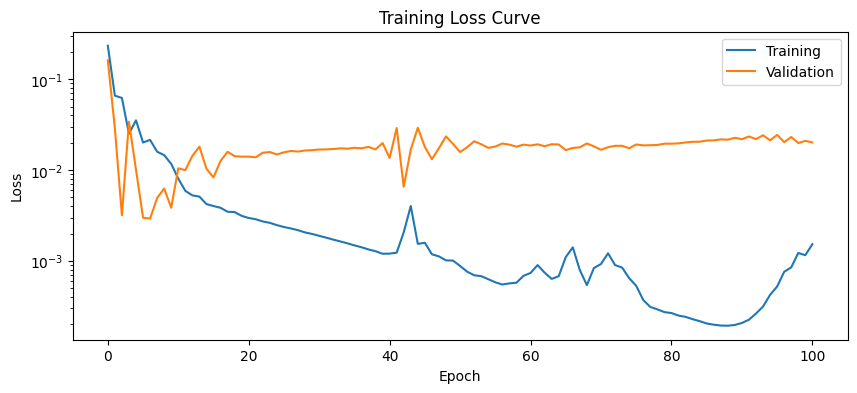

MSE: 0.0304, MAE: 0.1581, RMSE: 0.1744
Model saved as models/lstm_yearly_consumption_prediction_20250207-143007.pth
Layer (type:depth-idx)                   Output Shape              Param #
GRU2                                     [4, 1]                    --
├─GRU: 1-1                               [4, 12, 128]              54,144
├─Linear: 1-2                            [4, 1]                    129
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.60
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.22
Estimated Total Size (MB): 0.27


Epoch 1/100
Epoch 0: Train Loss = 0.1614, Val Loss = 0.0623


Epoch 11/100
Epoch 10: Train Loss = 0.0053, Val Loss = 0.0085


Epoch 21/100
Epoch 20: Train Loss = 0.0026, Val Loss = 0.0129


Epoch 31/100
Epoch 30: Train Loss = 0.0016, Val Loss = 0.0141


Epoch 41/100
Epoch 40: Train Loss = 0.0009, Val Loss = 0.0147


Epoch 51/100
Epoch 50: Train Loss = 0.0005, Val Loss = 0.0153


Epoch 61/100
Epoch 60: Train Loss = 0.0003, Val Loss = 0.0166


Epoch 71/100
Epoch 70: Train Loss = 0.0004, Val Loss = 0.0292


Epoch 81/100
Epoch 80: Train Loss = 0.0013, Val Loss = 0.0183


Epoch 91/100
Epoch 90: Train Loss = 0.0002, Val Loss = 0.0133


Epoch 101/100
Epoch 100: Train Loss = 0.0001, Val Loss = 0.0147


Test Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1364.45batch/s]


2
5 5
(5, 1) (5, 1)
(5,) (5,)


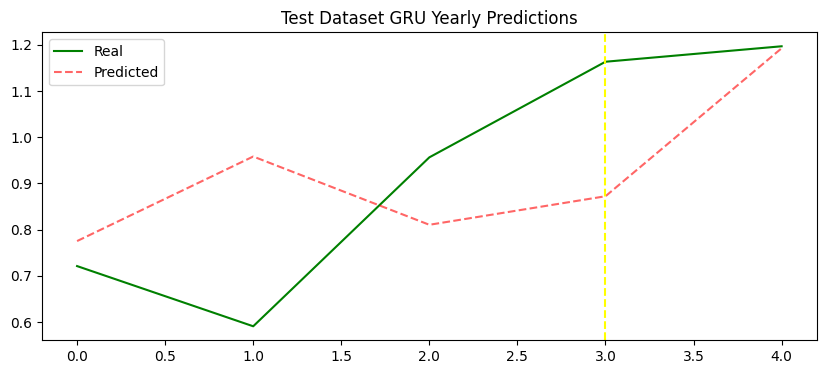

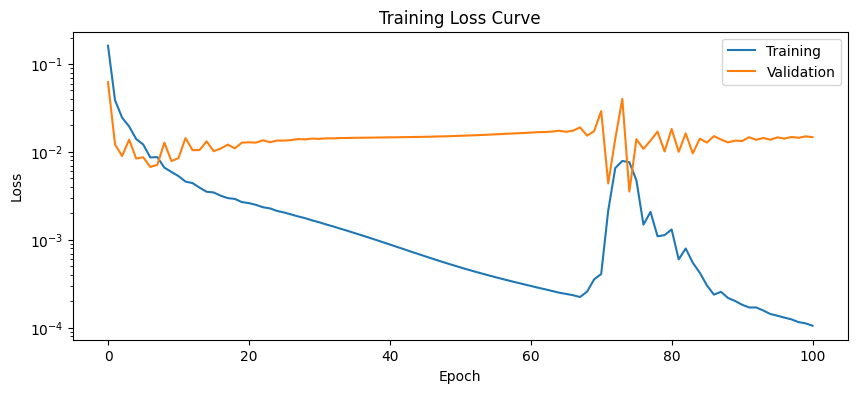

MSE: 0.0272, MAE: 0.1420, RMSE: 0.1649
Model saved as models/gru_yearly_consumption_prediction_20250207-143008.pth


In [72]:
#train_lstm_model
#save_model
#calculate_metrics

###################################
#configuration pytorch settings
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

###################################

dataset = read_csv('household_power_consumption_processed_with_features.csv', header=0)

missing_cols = dataset.columns[dataset.isna().all()]
print("Columns with all NaN values:", missing_cols.tolist())

features = ["Next_Day_Hourly_Consumption", "Next_Week_Daily_Consumption",
            "Next_Month_Daily_Consumption", "Next_Year_Monthly_Consumption"] # features to drop

dataset = dataset.drop(columns=features)

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
# rest is TEST_RATIO

# Size of LSTM hidden state
LSTM_HIDDEN_SIZE = 128

LSTM_NUM_LAYERS = 1

# Size of GRU hidden state
GRU_HIDDEN_SIZE = 128

GRU_NUM_LAYERS = 1

# Size of CNN LSTM hidden state (NOT USED)
CNN_LSTM_HIDDEN_SIZE = 50

# Optimizer learning rate
LEARNING_RATE = 0.004

TRAINING_EPOCHS = 100

#BATCH_SIZE = 64

#default is 0
L2_REGULARIZATION = 1e-5
#L2_REGULARIZATION = 0

NUM_AUTO_FEATURES = 9

#Try shuffling the train dataset batches after creating the sliding windows properlly 
SHUFFLE = False

LOSS = torch.nn.MSELoss()

DATASET_RATIO = len(dataset)

###################################
########### TEST PARAMETERS FOR LATER
sliding_window_range_size = {
    "hourly": [12, 24],
    "weekly": [7, 30],
    "monthly": [30, 90],
    "yearly": [12, 36]
}

sliding_window_size_minute = {
    "hourly": 60,
    "weekly": 60*24*7,
    "monthly": 60*24*30,
    "yearly": 60*24*365
}

batch_sizes_minute = {
    "hourly": 256,
    "weekly": 256,
    "monthly": 256,
    "yearly": 256
}

sliding_window_size_hour = {
    "hourly": 24,
    "weekly": 24*7,
    "monthly": 24*30,
    "yearly": 24*365
}

batch_sizes_hour = {
    "hourly": 64,
    "weekly": 64,
    "monthly": 64,
    "yearly": 64
}

###################################

sampling_periods = {
    "hourly": "h",
    "weekly": "D",
    "monthly": "D",
    "yearly": "M"
}

sliding_window_size = {
    "hourly": 24,
    "weekly": 7,
    "monthly": 30,
    "yearly": 12
}

batch_sizes = {
    "hourly": 64,
    "weekly": 32,
    "monthly": 16,
    "yearly": 4
}

model_name = "lstm"
timestamp = "Datetime"
target = "Global_active_power"

#na_columns = ["Global_active_power_daily_diff", "Global_active_power_annual_diff"]
dropped_columns = []

manually_selected_features = ["Season", "Is_Holiday", "Is_Weekend"]
#manually_selected_features = []

FIXED_SAMPLING = False
FIXED_SAMPLING_VALUE = "h" #"min"

for period_key, period_value in sampling_periods.items():
    
    df = dataset.head(DATASET_RATIO)
    
    df = df.drop(columns=dropped_columns) #drop problematic columns
    
    df[timestamp] = pd.to_datetime(df[timestamp])

    if FIXED_SAMPLING:
        df = df.resample(FIXED_SAMPLING_VALUE, on=timestamp).mean()
        if FIXED_SAMPLING_VALUE == "h":
            batch_size = batch_sizes_hour[period_key]
            window_size = sliding_window_size_hour[period_key]
        elif FIXED_SAMPLING_VALUE == "min":
            batch_size = batch_sizes_minute[period_key]
            window_size = sliding_window_size_minute[period_key]
    else:
        df = df.resample(period_value, on=timestamp).mean()   # Moyennes horaires
        batch_size = batch_sizes[period_key]
        window_size = sliding_window_size[period_key]

    print(f"Training for {period_key} (sampling for {window_size} - {"FIXED SAMPLING" if FIXED_SAMPLING else "auto"})")

    print(df.isna().sum(), df.shape) 
    df = df.interpolate()
    df.dropna(inplace=True)
    print(df.isna().sum(), df.shape) 
 
    selected_features = select_features(df.drop(columns=[target]), df[target], NUM_AUTO_FEATURES).tolist()
    selected_features = list(set(selected_features + manually_selected_features))
    print(selected_features)
    #selected_features = ['Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    input_size = len(selected_features)  # Number of selected input features
    
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[selected_features + [target]])  # Include target
    df_scaled = pd.DataFrame(df_scaled, columns=selected_features + [target])
    
    #lookback = 24  # Example: use past 24 hours
    target_col = df_scaled.columns.get_loc(target)  # Target index
    
    X, y = create_sequences(df_scaled, target_col, lookback=window_size)
    
    train_size = int(len(X) * TRAIN_RATIO)
    val_size = int(len(X) * VAL_RATIO)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
    
    print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
    
    train_loader, val_loader, test_loader = load_torch_dataset(X_train, y_train, 
                                                               X_val, y_val, 
                                                               X_test, y_test, 
                                                               batch_size=batch_size,
                                                              train_shuffle=SHUFFLE)
    models = {
        "lstm": LSTM2(LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS, in_size=input_size).to(device),
        "gru": GRU2(GRU_HIDDEN_SIZE, num_layers=GRU_NUM_LAYERS, in_size=input_size).to(device)
    }

    for model_name, model_value in models.items():
    
        model = model_value
        
        print(summary(model, (batch_size, window_size, input_size)))
    
        opt = get_optimizer(model, LEARNING_RATE, L2_REGULARIZATION)
    
        best_model, train_loss, val_loss = train_lstm_model(model, train_loader, val_loader, test_loader, 
                                                            scaler, opt, LOSS, features=selected_features, train_size=val_size,
                                                            epochs=TRAINING_EPOCHS, device=device, is_lstm=model_name == "lstm",
                                                           title=model_name.upper() + f" {period_key.capitalize()}")
    
        mse, mae, rmse = calculate_metrics(best_model, test_loader, device)
        print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
        save_model(best_model, model_name + f"_{period_key}", "consumption_prediction")

Ci-dessus, on affiche les différentes prédictions réalisées par chaque modèle, où on constate que le modèle LSTM obtient ici la meilleure prédiction par rapport à GRU ou LSTM.  
L'observation des résultats est que pour certaines étapes de la prédiction de la consommation sur la journée ou sur le mois ont des résultats variables. Ceci peut être dû à plusieurs facteurs :
* La taille/complexité du modèle qui n'arrive pas à tirer des données pertinentes à partir d'un nombre de données limité (70 000 paramètres pour LSTM et 50 000 pour GRU d'après `torchinfo`).
  Dans ce cas, mettre à l'aléatoire l'ordre des batchs du dataset d'entrainement (qui n'est pas conseiller pour une prédiction sur série temporelle) permet parfois d'obtenir de meilleurs résultats, au sacrifice de sa capacité de prédiction générale (Train/Val loss par epoch instable).
* Le manque de donnée durant les prédictions sur les mois et années


In [ ]:
#criterion = nn.MSELoss()  # Since we are predicting a continuous value
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#
#num_epochs = 20
#
#for epoch in range(num_epochs):
#    model.train()
#    total_train_loss = 0
#
#    for X_batch, y_batch in train_loader:
#        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#        optimizer.zero_grad()
#        y_pred, _ = model(X_batch)  # Forward pass
#        loss = criterion(y_pred, y_batch)  # Compute loss
#        loss.backward()  # Backpropagation
#        optimizer.step()  # Update weights
#        total_train_loss += loss.item()
#
#    # Validation phase
#    model.eval()
#    total_val_loss = 0
#    with torch.no_grad():
#        for X_batch, y_batch in val_loader:
#            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#            y_pred, _ = model(X_batch)
#            val_loss = criterion(y_pred, y_batch)
#            total_val_loss += val_loss.item()
#
#    print(f"Epoch {epoch+1}: Train Loss: {total_train_loss/len(train_loader):.4f}, Validation Loss: {total_val_loss/len(val_loader):.4f}")
#
#model.eval()
#test_preds, test_actuals = [], []
#
#with torch.no_grad():
#    for X_batch, y_batch in test_loader:
#        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#        preds, _ = model(X_batch)
#        test_preds.extend(preds.cpu().numpy())
#        test_actuals.extend(y_batch.cpu().numpy())
#
## Convert to NumPy
#test_preds = np.array(test_preds).reshape(-1, 1)
#test_actuals = np.array(test_actuals).reshape(-1, 1)
#
## Convert back to original scale (if needed)
#test_preds = scaler.inverse_transform(np.hstack([np.zeros((test_preds.shape[0], len(selected_features))), test_preds]))[:, -1]
#test_actuals = scaler.inverse_transform(np.hstack([np.zeros((test_actuals.shape[0], len(selected_features))), test_actuals]))[:, -1]
#
## Plot Predictions vs Actual
#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 5))
#plt.plot(test_actuals[:100], label="Actual", linestyle="dashed")
#plt.plot(test_preds[:100], label="Predicted")
#plt.legend()
#plt.title("LSTM Predictions vs Actual Values")
#plt.show()